In [1]:
import pandas as pd
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
train_data = pd.read_csv('../train.csv')
train_data.head(10)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.00000,0.000000,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.00000,0.000000,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.00000,0.000000,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.00000,0.000000,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.031250
5,8,Magnolia_Salicifolia,0.070312,0.093750,0.033203,0.001953,0.000000,0.152340,0.007812,0.0,...,0.145510,0.000000,0.041992,0.000000,0.005859,0.00000,0.000000,0.000000,0.001953,0.013672
6,10,Quercus_Canariensis,0.021484,0.031250,0.017578,0.009766,0.001953,0.042969,0.039062,0.0,...,0.085938,0.000000,0.040039,0.000000,0.009766,0.00000,0.000000,0.000000,0.039062,0.003906
7,11,Quercus_Rubra,0.000000,0.000000,0.037109,0.050781,0.003906,0.000000,0.003906,0.0,...,0.038086,0.025391,0.009766,0.002930,0.021484,0.00000,0.037109,0.006836,0.002930,0.036133
8,14,Quercus_Brantii,0.005859,0.001953,0.033203,0.015625,0.001953,0.000000,0.023438,0.0,...,0.000000,0.000000,0.008789,0.000000,0.017578,0.00000,0.000000,0.000977,0.033203,0.074219
9,15,Salix_Fragilis,0.000000,0.000000,0.009766,0.037109,0.072266,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.070312,0.013672,0.19238,0.000000,0.074219,0.000000,0.000000


In [4]:
train_data.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

In [5]:
train_data.shape

(990, 194)

In [6]:
species = set(train_data.species)
len(species)

99

In [8]:
images = {}
for id in train_data['id']:
    images[id] = np.array(Image.open('../images/{}.jpg'.format(id)))

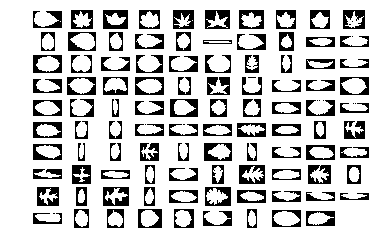

In [9]:
_, plts = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        plts[i][j].axis('Off')
i, groups = 0, train_data.groupby('species')
for group in groups:
    sp, sp_data = group[0], group[1]
    plts[i//10][i%10].imshow(images[sp_data.iloc[0].id], 'gray')
    i += 1
plt.show()

In [10]:
X = train_data.drop(['species', 'id'], axis=1)
y = train_data.species

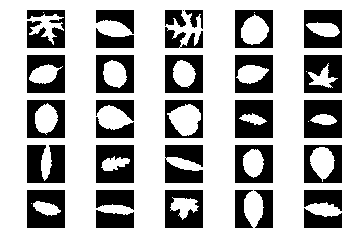

In [1]:
data_path = './tfrecords/train_data_1.tfrecords'

def decode(serialized_example):
    feature_dic = {'image': tf.FixedLenFeature([], tf.string),
                   'num': tf.FixedLenFeature([], tf.string),
                   'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, features=feature_dic)
    return features['image'], features['num'], features['label']


dataset = tf.data.TFRecordDataset([data_path]).map(decode)
iterator = dataset.make_one_shot_iterator()
iter_image, iter_num, iter_label = iterator.get_next()

counter = 0
images = []
with tf.Session() as sess:
    try:
        while True:
            bytes_image, bytes_num, bytes_label = sess.run((iter_image, iter_num, iter_label))
            image, num, label = np.fromstring(bytes_image, dtype=np.bool), \
                                np.fromstring(bytes_num, dtype=np.float64), \
                                np.fromstring(bytes_label, dtype=np.bool)
            # print(image.shape, num.shape, label.shape)
            images.append(np.reshape(image, (96, 96)))
            counter += 1
            if counter==25:
                break
    except tf.errors.OutOfRangeError:
        pass

from matplotlib import pyplot as plt

_, plts = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        plts[i][j].axis('Off')
for i, image in enumerate(images):
    plts[i//5][i%5].imshow(image, 'gray')
    i += 1
plt.show()